In [1]:
import src
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from warnings import filterwarnings
# Pandas will give a lot of warning while I am mutating data frames in functions.
filterwarnings('ignore')
# Matplot lib inline
%matplotlib inline

### Choice of data and goal
- Data frames come from the same website so I can join on the column tconst with no lost observation other than
    differences dataframe length
- I want to create a dataframe that tags each observation with the genre that is in it's genre list
- Once I have merged, cleaned and added the genre boolean columns I will do rating by genre of recent years and 
    sufficently high vote count to convince me the findings are valid
- Once I have a dataframe with individual genres, I want to merge that with a dataframe containing the budgets for each movie. 


In [2]:
df_title = pd.read_csv('../zippedData/imdb.title.basics.csv.gz')
df_ratings = pd.read_csv('../zippedData/imdb.title.ratings.csv.gz')
df_budgets = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')
print(f'df_title has a shape of {df_title.shape} and df_ratings has a shape of {df_ratings.shape}')

df_title has a shape of (146144, 6) and df_ratings has a shape of (73856, 3)


In [3]:
# merge the two data sets on tconst:
df_merge = df_title.merge(df_ratings, on='tconst', how='inner')
print(f'df_merge has a shape of {df_merge.shape}')

# remove all null values from the genres column
df = src.remove_null_genre(df_merge, 'genres')

#coerce the genres to a list:
df.genres = src.coerce_to_list(df, 'genres')

# Create a data frame containing only data released since the year 2000 and before 2020
df_scaffold = df[(df.start_year<2020)]
# choice of column for the data frames
df_scaffold = df_scaffold[['tconst',
                           'primary_title', 
                           'genres', 
                           'numvotes', 
                           'averagerating',
                           'start_year', 
                           'runtime_minutes']]

# Create boolean sereis for each genre in list and append it to a scaffold df documentation in src
df_genres = src.generate_genre_dataframe(df_scaffold)
print(f'df_genres has a shape of {df_genres.shape}')

df_merge has a shape of (73856, 8)
df_genres has a shape of (73052, 33)


In [4]:
df_genres.head()

,tconst,primary_title,genres,numvotes,averagerating,start_year,runtime_minutes,Thriller,Reality-TV,Sci-Fi,...,Mystery,Biography,Drama,Fantasy,Documentary,Adventure,Adult,History,Game-Show,Sport
0,tt0063540,Sunghursh,"[Action, Crime, Drama]",77,7.0,2013,175.0,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,tt0066787,One Day Before the Rainy Season,"[Biography, Drama]",43,7.2,2019,114.0,False,False,False,...,False,True,True,False,False,False,False,False,False,False
2,tt0069049,The Other Side of the Wind,[Drama],4517,6.9,2018,122.0,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,tt0069204,Sabse Bada Sukh,"[Comedy, Drama]",13,6.1,2018,NaN,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,tt0100275,The Wandering Soap Opera,"[Comedy, Drama, Fantasy]",119,6.5,2017,80.0,False,False,False,...,False,False,True,True,False,False,False,False,False,False


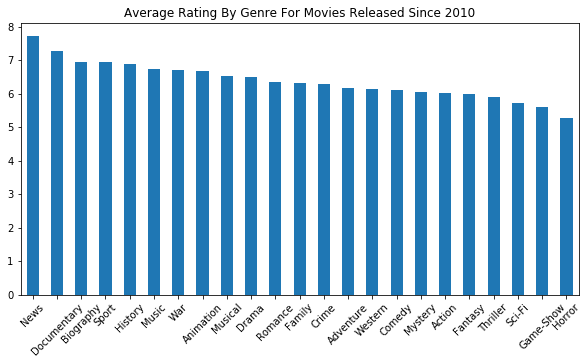

In [5]:
# Generate a plot of the data and visualise the ratings per genre. check documentation in src
df_genres_highvotes = df_genres[df_genres.numvotes >1000]
df_ratings = src.genre_pandas_mean(df_genres_highvotes, 'averagerating')

df_ratings.plot(kind='bar', figsize=(10,5), title='Average Rating By Genre For Movies Released Since 2010', legend=False)
plt.xticks(rotation=45);

In [6]:
# Change the genres back to a string before we save for ease of further analysis
df_genres.genres = src.list_to_string(df_genres, 'genres')

# Save the data frame as a csv and continue on to budget by genre
df_genres.to_csv('basics-ratings-genre.csv', index=False)


# change the genres back to a list as my graphing functions require it to be in that format
# df_genres.genres = src.coerce_to_list_by_space(df_genres, 'genres')

In [7]:
df_genres.genres

0          Action Crime Drama
1             Biography Drama
2                       Drama
3                Comedy Drama
4        Comedy Drama Fantasy
                 ...         
73850             Documentary
73851             Documentary
73852            Drama Family
73853             Documentary
73855             Documentary
Name: genres, Length: 73052, dtype: object

In [8]:
# Before a merge, let's clean up the data frames with a string cleaning function. lower allthe titles and remove whitespace
df_budgets.movie=src.string_cleaner(df_budgets.movie)
df_genres.primary_title=src.string_cleaner(df_genres.primary_title)

In [9]:
# perform a merge on genres left on primary_title right on movie
df =df_genres.merge(df_budgets, how='inner', left_on='primary_title', right_on='movie')

In [10]:
df.shape

(2927, 39)

In [11]:
# Now that we have our dataframe, albeit heavily reduced in size, we should cleanup the columns and save it
df.head(3)

,tconst,primary_title,genres,numvotes,averagerating,start_year,runtime_minutes,Thriller,Reality-TV,Sci-Fi,...,Adult,History,Game-Show,Sport,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,foodfight!,Action Animation Comedy,8248,1.9,2012,91.0,False,False,False,...,False,False,False,False,26,"Dec 31, 2012",foodfight!,"$45,000,000",$0,"$73,706"
1,tt0337692,on the road,Adventure Drama Romance,37886,6.1,2012,124.0,False,False,False,...,False,False,False,False,17,"Mar 22, 2013",on the road,"$25,000,000","$720,828","$9,313,302"
2,tt4339118,on the road,Drama,6,6.0,2014,89.0,False,False,False,...,False,False,False,False,17,"Mar 22, 2013",on the road,"$25,000,000","$720,828","$9,313,302"


In [12]:
# Use the string to float function we built to fix these columns
df.production_budget = src.string_to_float(df.production_budget)
df.domestic_budget = src.string_to_float(df.domestic_gross)
df.worldwide_gross = src.string_to_float(df.worldwide_gross)

In [13]:
# Create a release year column
df.release_date = pd.to_datetime(df.release_date)
df['year'] = df.release_date.dt.strftime('%Y').astype(int)
df['month'] = df.release_date.dt.strftime('%m').astype(int)

# Filter movie by start date being after 2010 and onwards
df = df[df.year > 2009]
len(df)

2261

In [14]:

# Create a return on investment column
df['roi'] = (df.worldwide_gross-df.production_budget)/df.production_budget*100

In [15]:
df_to_plot = src.genre_pandas_mean(df, 'roi')
df_to_plot.plot(kind='barh', legend=False,figsize=(12,6))
plt.xticks(rotation = 45)
plt.title('Mean ROI of Each Genre of Movies Released Between the Years 2010-2019')
plt.xlabel('ROI %', size = 15)
plt.ylabel('Movie Genre', size = 15);
plt.savefig('roi_genre.png')

KeyError: 'C'

In [112]:
df.genre = src.c

,tconst,primary_title,genres,numvotes,averagerating,start_year,runtime_minutes,Adult,Sport,Sci-Fi,...,Action,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,month,roi
0,tt0249516,foodfight!,"[Action, Animation, Comedy]",8248,1.9,2012,91.0,False,False,False,...,True,26,2012-12-31,foodfight!,45000000.0,$0,73706.0,2012,12,-99.836209
1,tt0337692,on the road,"[Adventure, Drama, Romance]",37886,6.1,2012,124.0,False,False,False,...,False,17,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
2,tt4339118,on the road,[Drama],6,6.0,2014,89.0,False,False,False,...,False,17,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
3,tt5647250,on the road,[Drama],127,5.7,2016,121.0,False,False,False,...,False,17,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
4,tt0359950,the secret life of walter mitty,"[Adventure, Comedy, Drama]",275300,7.3,2013,114.0,False,False,False,...,False,37,2013-12-25,the secret life of walter mitty,91000000.0,"$58,236,838",187861183.0,2013,12,106.440860


In [18]:
df[['primary_title', 'tconst']].to_csv("../rawdata/title.csv", index=False)

In [16]:
# drop extra columns that we didn't use.
df.head()
df.drop(columns= ["primary_title",
                 'id'],
        inplace = True
       )

# Save as a new csv!
df.to_csv('genres-budget.csv', index=False)


In [17]:
df.head()

,tconst,genres,numvotes,averagerating,start_year,runtime_minutes,Adult,Sport,Sci-Fi,Fantasy,...,Comedy,Action,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,month,roi
0,tt0249516,"[Action, Animation, Comedy]",8248,1.9,2012,91.0,False,False,False,False,...,True,True,2012-12-31,foodfight!,45000000.0,$0,73706.0,2012,12,-99.836209
1,tt0337692,"[Adventure, Drama, Romance]",37886,6.1,2012,124.0,False,False,False,False,...,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
2,tt4339118,[Drama],6,6.0,2014,89.0,False,False,False,False,...,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
3,tt5647250,[Drama],127,5.7,2016,121.0,False,False,False,False,...,False,False,2013-03-22,on the road,25000000.0,"$720,828",9313302.0,2013,3,-62.746792
4,tt0359950,"[Adventure, Comedy, Drama]",275300,7.3,2013,114.0,False,False,False,False,...,True,False,2013-12-25,the secret life of walter mitty,91000000.0,"$58,236,838",187861183.0,2013,12,106.440860


In [18]:
df = pd.read_csv('genres-budget.csv')
# # Next question is what combination of genres is best?

# # reloud the dataframe with string values for genres
# df_combo_genre = pd.read_csv('genres-budget.csv')
# df.sort_values('roi', ascending=False)[:26].groupby(['genres']).tconst.count().sort_values(ascending=False)

In [19]:
df = src.string_from_list(df_combo_genre, 'genres')

NameError: name 'df_combo_genre' is not defined

In [ ]:
grouped_top_22_genres = df.groupby(['genres']).roi.mean().sort_values(ascending=False)[:22]

grouped_top_22_genres.plot(kind='barh', legend=False,figsize=(12,6))
plt.title('Mean ROI of Highest Combination of Genre of Movies Released Since the Year 2010')
plt.xlabel('ROI %', size = 15)
plt.ylabel('Movie Genre', size = 15)
plt.savefig('roi_genre_combo.png')

In [ ]:
df.groupby(['genres']).roi.mean().sort_values(ascending=False)[:22]

In [96]:
# Using Aidan categorization method, I want to know which genre from each price point yeilds the best return on investment
df['production_category'] = df['production_budget'].apply(lambda x: src.categorize_production(x))
df.groupby(['production_category']).tconst.count().plot(kind='bar');

KeyError: 'production_budget'

In [21]:
df_small = df[df.production_category == 'small']
df_small_grouped = df_small.groupby(['month']).roi.mean()
df_medium =df[df.production_category == 'medium']
df_large = df[df.production_category == 'large']

In [95]:
df.genres = src.string_from_list(df, 'genres')
df.genres = src.coerce_to_list(df, 'genres')
df.genres

KeyError: 'genres'

In [35]:
df.month

0       12
1        3
2        3
3        3
4       12
        ..
2256     2
2257     8
2258    12
2259     9
2260     3
Name: month, Length: 2261, dtype: int64

In [31]:
genres = src.genre_set_list(df.genres)

In [94]:
# for each genre, create a series and update a dictionary with it
genre_dict = {}
for genre in genres:
    genre_dict.update({genre: df[df[genre] == True]})

KeyError: 'Sport'

In [49]:
# Drop unwanted columns from each dataframe
for genre in genre_dict:
    genre_dict[genre].drop(columns=[
        'genres',
        'release_date',
        'worldwide_gross',
        'domestic_gross',
        'start_year',
        'numvotes',
        'averagerating',
        'production_budget'

    ], inplace=True)
    genre_dict[genre]['genre'] = genre

In [55]:
genre_dict[
    'Action'
]

,tconst,runtime_minutes,Adult,Sport,Sci-Fi,Fantasy,News,Western,Thriller,Family,...,Crime,Musical,Comedy,Action,movie,year,month,roi,production_category,genre
0,tt0249516,91.0,False,False,False,False,False,False,False,False,...,False,False,True,True,foodfight!,2012,12,-99.836209,medium,Action
5,tt0365907,114.0,False,False,False,False,False,False,False,False,...,True,False,False,True,a walk among the tombstones,2014,9,121.816382,medium,Action
6,tt0369610,124.0,False,False,True,False,False,False,False,False,...,False,False,False,True,jurassic world,2015,6,666.909239,large,Action
11,tt0401729,132.0,False,False,True,False,False,False,False,False,...,False,False,False,True,john carter,2012,3,2.828400,large,Action
13,tt0429493,117.0,False,False,False,False,False,False,True,False,...,False,False,False,True,the a-team,2010,6,61.128337,large,Action
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,tt7137846,88.0,False,False,False,False,False,False,False,False,...,True,False,False,True,breaking in,2018,5,756.860333,medium,Action
2247,tt7424200,84.0,False,False,False,False,False,False,False,False,...,False,False,True,True,teen titans go! to the movies,2018,7,416.205930,medium,Action
2250,tt7690670,116.0,False,False,False,False,False,False,True,False,...,True,False,False,True,superfly,2018,6,29.522381,medium,Action
2254,tt7961060,100.0,False,False,False,False,False,False,False,False,...,False,False,False,True,dragon ball super: broly,2019,1,1344.091235,medium,Action


In [93]:
# Remove all columns apart from those necessary for analysis
for genre in genre_dict:
    genre_dict[genre] = genre_dict[genre][
        [
            'tconst',
            'genre',
            'roi',
            'month',
            'worldwide_gross',
            'production_category'
        ]
    ]

# Generate concatenation list
concat_list = []
for genre in genre_dict:
    concat_list.append(genre_dict[genre])

KeyError: "['worldwide_gross'] not in index"

In [59]:
month_roi_genre = (pd.concat(concat_list))#.groupby(['tconst']).runtime_minutes.count()).mean()

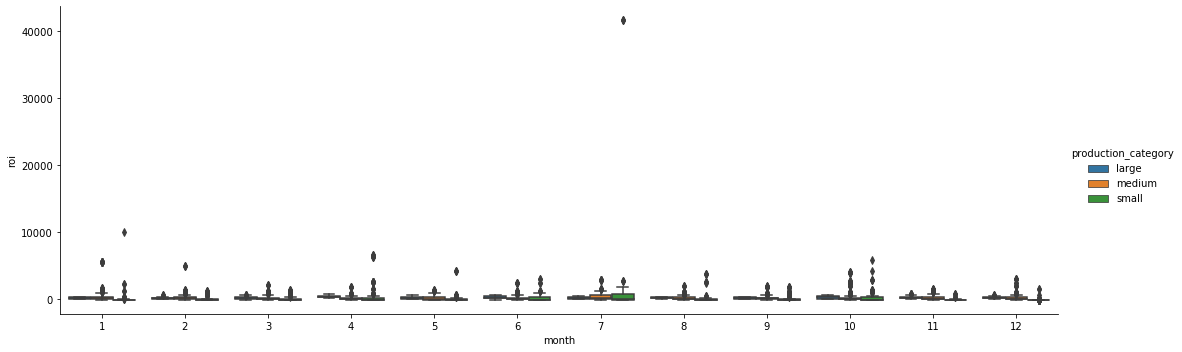

In [64]:


sns.catplot(x = 'month', y = 'roi', hue = 'production_category', data = month_roi_genre, kind = 'box', height = 5, aspect =3)

In [68]:
# one outlier in july is messing up all of the data
# Remove the
month_roi_genre[month_roi_genre.month==7].sort_values('roi', ascending=False)

,tconst,genre,roi,month,production_category
1551,tt2309260,Horror,41556.4740,7,small
1551,tt2309260,Thriller,41556.4740,7,small
1551,tt2309260,Mystery,41556.4740,7,small
217,tt1085448,Drama,2876.1302,7,medium
218,tt1646127,Thriller,2876.1302,7,medium
...,...,...,...,...,...
1181,tt2181875,Drama,-100.0000,7,medium
777,tt1568341,Drama,-100.0000,7,small
1224,tt1884318,Horror,-100.0000,7,small
1786,tt2825768,Documentary,-100.0000,7,small


In [70]:
df[df.tconst == 'tt2309260']

,tconst,genres,numvotes,averagerating,start_year,runtime_minutes,Adult,Sport,Sci-Fi,Fantasy,...,Action,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,month,roi,production_category
1551,tt2309260,"[Horror, Mystery, Thriller]",17763,4.2,2015,81.0,False,False,False,False,...,False,2015-07-10,the gallows,100000.0,"$22,764,410",41656474.0,2015,7,41556.474,small


In [71]:
df_cleaned = month_roi_genre[month_roi_genre.tconst != 'tt2309260']

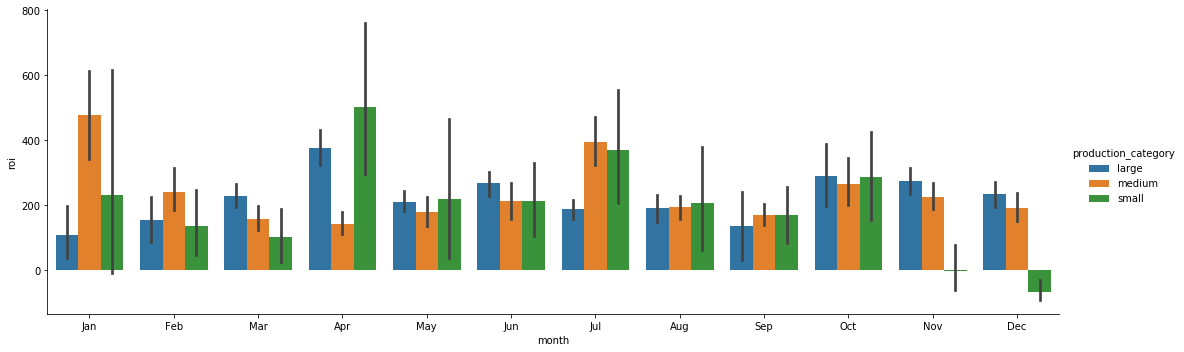

In [81]:

sns.catplot(x = 'month', y = 'roi', hue = 'production_category', data = df_cleaned, kind = 'bar', height = 5, aspect =3)
plt.xticks(ticks= list(range(0,12)), labels=['Jan', 'Feb','Mar','Apr', "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]);





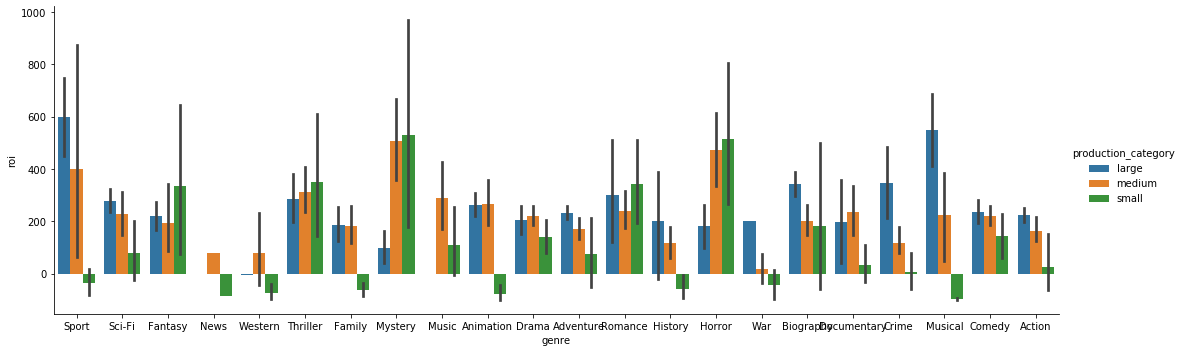

In [82]:

sns.catplot(x = 'genre', y = 'roi', hue = 'production_category', data = df_cleaned, kind = 'bar', height = 5, aspect =3);



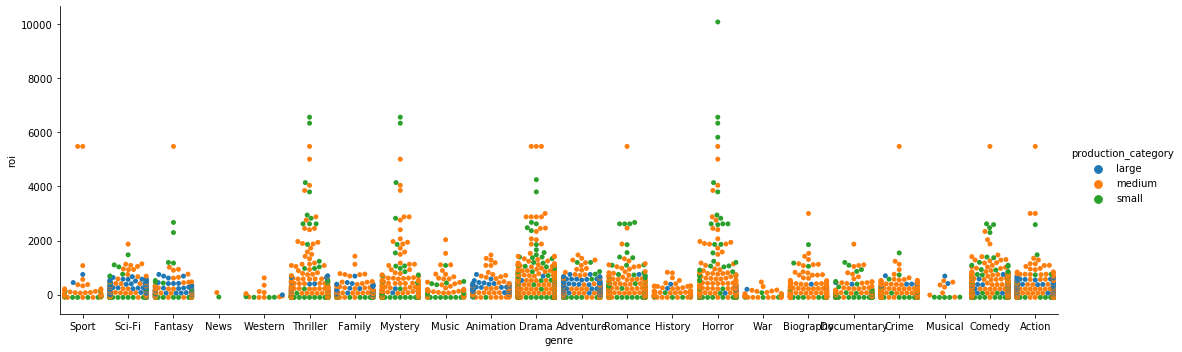

In [83]:
sns.catplot(x = 'genre', y = 'roi', hue = 'production_category', data = df_cleaned, kind = 'swarm', height = 5, aspect =3);


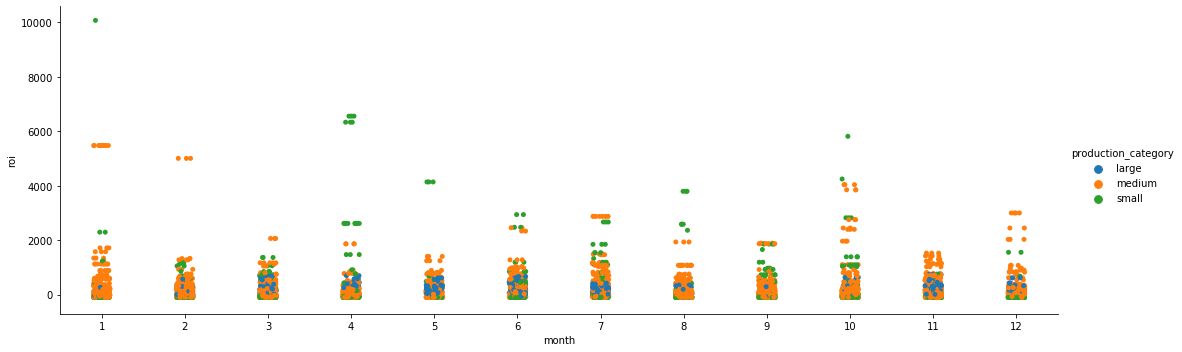

In [88]:
sns.catplot(x = 'month', y = 'roi', hue = 'production_category', data = df_cleaned, kind = 'strip', height = 5, aspect =3);


In [89]:
df_cleaned.to_csv('genre-month-roi.csv', index=False)

In [90]:
df = pd.read_csv('genre-month-roi.csv')

,tconst,genre,roi,month,production_category
0,tt4283448,Sport,447.422252,6,large
1,tt0453562,Sport,214.421616,4,medium
2,tt0964517,Sport,1075.112618,12,medium
3,tt1130964,Sport,-93.197350,3,medium
4,tt1210166,Sport,122.601670,9,medium
